fuel used:  2.072707872464889 kg, out of  1000 kg
Radial burn integration failed with status -1: Required step size is less than spacing between numbers.


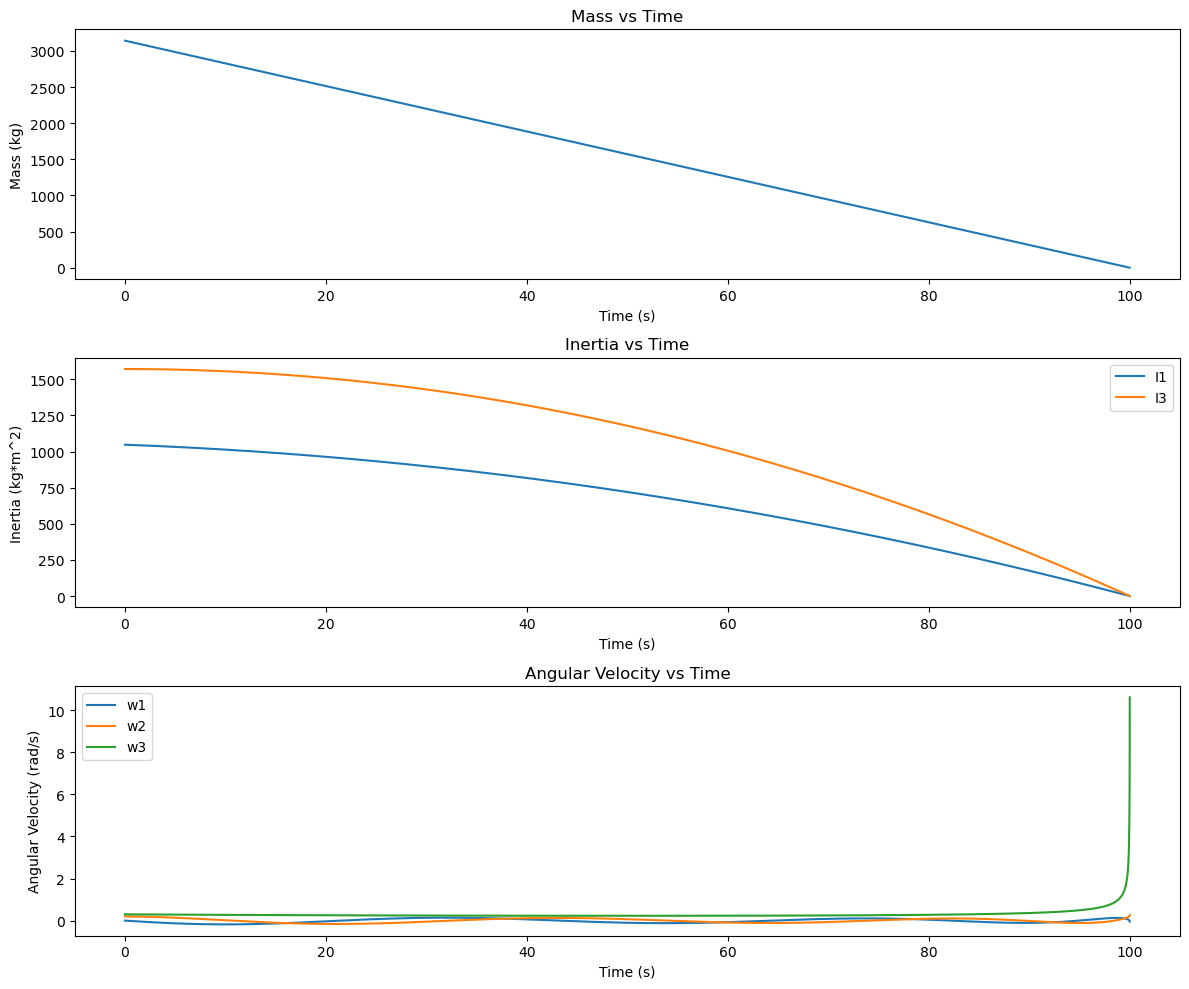

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math

# Constants for the radial burn simulation
rho_ini = 1000
L = 1  # m
h = L / 2  # m
R = 2 * h  # m
w0 = 0.2  # rad/s
w10 = 0  # rad/s
w20 = w0  # rad/s
w30 = 0.3  # rad/s
mf0 = np.pi * R**2 * L * rho_ini  # kg
I10 = mf0 * (R**2 / 4 + h**2 / 3)  # kg*m^2
I30 = mf0 * R**2 / 2  # kg*m^2
Theta0 = 0
F0 = 0
tb = 100  # s
m_dot = -mf0 / tb
rsq0 = 0
q0 = [1, 0, 0, 0]  # (w, x, y, z)
Y0 = [mf0, I10, I30, w10, w20, w30, Theta0, F0, rsq0] + q0

# Constants for the extended burn simulation
mu = 398600.4418  # km^3/s^2 (gravitational parameter of Earth)
sma = 7000  # km (semi-major axis of the target's orbit)
n = np.sqrt(mu / sma**3)  # mean motion of the target
r0_chaser = np.array([10.0, 9.0, -30.0])  # Initial relative position of chaser, km
v0_chaser = np.array([3, 5, 0.1])  # Initial relative velocity of chaser, km/s
thrust_start_time = 200  # Time delay before thrust starts in seconds
thrust_duration = 600    # Thrust duration in seconds
thrust_force = np.array([0, 100000, 0])  # Thrust force in N
specific_impulse = 3000  # Specific impulse of the propulsion system, seconds
fuel_mass_inital = 1000  # Initial mass of the fuel
spacecraft_mass = 4000  # Initial dry mass of the craft, kg
total_mass_initial = spacecraft_mass + fuel_mass_inital  # Initial total mass of the spacecraft

# Time parameters
t_final = 10000  # Total simulation time, seconds
dt = 10  # Time step, seconds

# Time array
t = np.arange(0, t_final, dt)

# Position and velocity arrays for the extended burn simulation
r_chaser = np.zeros((len(t), 3))
v_chaser = np.zeros((len(t), 3))

# Set initial conditions
r_chaser[0] = r0_chaser
v_chaser[0] = v0_chaser

# Function for the Clohessy-Wiltshire equations
def clohessy_wiltshire(r, v, t, n):
    x, y, z = r
    x_dot, y_dot, z_dot = v
    x_ddot = 3 * n**2 * x + 2 * n * y_dot
    y_ddot = -2 * n * x_dot
    z_ddot = -n**2 * z
    return np.array([x_dot, y_dot, z_dot]), np.array([x_ddot, y_ddot, z_ddot])

# Radial burn differential equations
def radialburn(t, w):
    m, I1, I3, w1, w2, w3, Theta, F, rsq, qw, qx, qy, qz = w
    md = m_dot
    rsqd = -md * (R**2 - rsq) / m
    I1d = md * (rsq / 2 + h**2 / 3)
    I3d = md * rsq
    ze = h
    w1d = (I1 - I3) * w2 * w3 / I1 - (I1d - md * (ze**2 + R**2 / 4)) * w1 / I1
    w2d = -(I1 - I3) * w1 * w3 / I1 - (I1d - md * (ze**2 + R**2 / 4)) * w2 / I1
    w3d = -(I3d - md * R**2 / 2) * w3 / I3
    Thetad = (1 - I3 / I1) * w3
    Fd = -(I1d - md * (ze**2 + R**2 / 4)) / I1
    omega_quat = np.array([0, w1, w2, w3])
    quat = np.array([qw, qx, qy, qz])
    quat_dot = 0.5 * np.array(quat_mult(quat, omega_quat))
    quat_norm = np.linalg.norm(quat)
    if quat_norm > 0:
        quat /= quat_norm
    wd = [md, I1d, I3d, w1d, w2d, w3d, Thetad, Fd, rsqd, quat_dot[0], quat_dot[1], quat_dot[2], quat_dot[3]]
    return wd

def quat_mult(q, r):
    w1, x1, y1, z1 = q
    w2, x2, y2, z2 = r
    return [
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ]

# Initialize the flag variable before the loop
fuel_depleted_flag = False
current_mass = total_mass_initial

# Simulation loop for the extended burn
for i in range(1, len(t)):
    r = r_chaser[i-1]
    v = v_chaser[i-1]
    v, a = clohessy_wiltshire(r, v, t[i], n)
    thrust_acceleration = np.array([0.0, 0.0, 0.0])
    if thrust_start_time <= t[i] <= (thrust_start_time + thrust_duration):
        if (current_mass - spacecraft_mass) > 0:
            exhaust_velocity = specific_impulse * 9.81
            thrust_acceleration = thrust_force / current_mass
            thrust_acceleration = thrust_acceleration * 1e-3
            current_mass = current_mass * math.exp((-(np.linalg.norm(thrust_acceleration) * dt)) / (exhaust_velocity))
        else:
            if not fuel_depleted_flag:
                fuel_depleted_flag = True
                print("fuel depleted at: ", t[i], "seconds")
            thrust_acceleration = np.array([0.0, 0.0, 0.0])
    total_acceleration = a + thrust_acceleration
    r_chaser[i] = r + v * dt
    v_chaser[i] = v + total_acceleration * dt

print("fuel used: ", (fuel_mass_inital - (current_mass - spacecraft_mass)), "kg, out of ", fuel_mass_inital, "kg")

# Solve the radial burn ODEs
dt_r = 0.01
t_eval_r = np.arange(0, tb, dt_r)
sol_r = solve_ivp(radialburn, [0, tb], Y0, t_eval=t_eval_r, atol=1e-6, rtol=1e-5)

# Check if the integration was successful
if sol_r.status == 0:
    print("Radial burn integration successful.")
else:
    print(f"Radial burn integration failed with status {sol_r.status}: {sol_r.message}")

# Extract results from the radial burn simulation
t_r = sol_r.t
mf = sol_r.y[0]
I1 = sol_r.y[1]
I3 = sol_r.y[2]
omega1 = sol_r.y[3]
omega2 = sol_r.y[4]
omega3 = sol_r.y[5]
Theta = sol_r.y[6]
F = sol_r.y[7]
rsq = sol_r.y[8]
qw = sol_r.y[9]
qx = sol_r.y[10]
qy = sol_r.y[11]
qz = sol_r.y[12]

# Plotting results
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(t_r, mf)
plt.xlabel('Time (s)')
plt.ylabel('Mass (kg)')
plt.title('Mass vs Time')

plt.subplot(3, 1, 2)
plt.plot(t_r, I1, label='I1')
plt.plot(t_r, I3, label='I3')
plt.xlabel('Time (s)')
plt.ylabel('Inertia (kg*m^2)')
plt.title('Inertia vs Time')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_r, omega1, label='w1')
plt.plot(t_r, omega2, label='w2')
plt.plot(t_r, omega3, label='w3')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Angular Velocity vs Time')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting with Plotly for interactive visualization
r_chaser_scaled = r_chaser / sma

trace = go.Scatter3d(
    x=r_chaser_scaled[:, 0],
    y=r_chaser_scaled[:, 1],
    z=r_chaser_scaled[:, 2],
    mode='markers',
    name='Chaser Satellite',
    marker=dict(
        color='blue',
        size=2
    )
)

initial_trace = go.Scatter3d(
    x=[r_chaser_scaled[0, 0]],
    y=[r_chaser_scaled[0, 1]],
    z=[r_chaser_scaled[0, 2]],
    mode='markers',
    name='Initial Position',
    marker=dict(
        color='black',
        size=5
    )
)

target_trace = go.Scatter3d(
    x=[0],
    y=[0],
    z=[0],
    mode='markers',
    name='Target Satellite',
    marker=dict(
        color='red',
        size=5
    )
)

thrust_start_trace = go.Scatter3d(
    x=[r_chaser_scaled[thrust_start_time, 0]],
    y=[r_chaser_scaled[thrust_start_time, 1]],
    z=[r_chaser_scaled[thrust_start_time, 2]],
    mode='markers',
    name='Thrust Start',
    marker=dict(
        color='green',
        size=5
    )
)

if (current_mass - spacecraft_mass) <= 0:
    thrust_end_trace = go.Scatter3d(
        x=[r_chaser_scaled[fuel_depleted_flag, 0]],
        y=[r_chaser_scaled[fuel_depleted_flag, 1]],
        z=[r_chaser_scaled[fuel_depleted_flag, 2]],
        mode='markers',
        name='Thrust End',
        marker=dict(
            color='yellow',
            size=5
        )
    )
else:
    thrust_end_trace = go.Scatter3d(
        x=[r_chaser_scaled[thrust_start_time + thrust_duration, 0]],
        y=[r_chaser_scaled[thrust_start_time + thrust_duration, 1]],
        z=[r_chaser_scaled[thrust_start_time + thrust_duration, 2]],
        mode='markers',
        name='Thrust End',
        marker=dict(
            color='yellow',
            size=5
        )
    )

layout = go.Layout(
    title='Relative Motion of the Chaser Satellite',
    scene=dict(
        xaxis=dict(title='X/a [km]'),
        yaxis=dict(title='Y/a [km]'),
        zaxis=dict(title='Z/a [km]')
    )
)

fig = go.Figure(data=[trace, target_trace, thrust_start_trace, thrust_end_trace, initial_trace], layout=layout)
fig.show()

